In [1]:
import os,time,itertools,pickle,imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import torch as t
from torch import cuda,nn,optim,utils
from torch.nn import functional as F
from torch.autograd import Variable
from torchvision import datasets,transforms

#DCGAN Model (Radford et.al 2015)

In [3]:
#ThePolice

class discriminator(nn.Module):
    # initializers
    def __init__(self, d):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init... for stable gradient flow across layers
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)             #LeakyReLU in all layers except last
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        #x = t.sigmoid(self.conv5(x))                        The output of D is no longer a probability now. 
        x = self.conv5(x)

        return x
      
#TheCulprit

class generator(nn.Module):
    # initializers
    def __init__(self, d):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)     #100-d latent space vector
        self.deconv1_bn = nn.BatchNorm2d(d*8)                     
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:   
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))  #ReLU all layers except last where tanh used
        x = F.relu(self.deconv2_bn(self.deconv2(x)))      
        x = F.relu(self.deconv3_bn(self.deconv3(x)))      
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = t.tanh(self.deconv5(x))

        return x
      
#WeightInitialiser
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

#Utilities

In [4]:
#Create Folder
if not os.path.isdir('MNIST_DCGAN_results'):
    os.mkdir('MNIST_DCGAN_results')
if not os.path.isdir('MNIST_DCGAN_results/Random_results'):
    os.mkdir('MNIST_DCGAN_results/Random_results')
if not os.path.isdir('MNIST_DCGAN_results/Fixed_results'):
    os.mkdir('MNIST_DCGAN_results/Fixed_results')


In [5]:
#Stackoverflow Stuff :P

fixed_z = Variable(t.Tensor(5 * 5, 100).normal_().view(-1, 100, 1, 1).cuda())  #Mod-2
def show_result(num_epoch, show = False, save = False, path = 'result.png', isFix=False):
    
    z = t.Tensor(5*5, 100).normal_().view(-1, 100, 1, 1)                       #Mod-2
    z = Variable(z.cuda())

    g.eval() #EvalMode
    
    if isFix:
        test_images = g(fixed_z)
    else:
        test_images = g(z)
    
    g.train() 

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [6]:
#Training Plotter

def train_plot(hist, show = False, save = False, path = 'Train_plot.png'):
    
    x = range(len(hist['D_loss']))

    y1 = hist['D_loss']
    y2 = hist['G_loss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iterations')
    plt.ylabel('Loss')

    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [7]:
#As mentioned in the paper
param = {
    "batch_sz" : 128,
    "lr" : 0.0002,
    "beta" : 0.5,
    "img_size" : 64,
    "lrD" : 0.00005,
    "lrG" : 0.00005,
    "clamp-lower" : 0.01,
    "clamp-upper" : 0.01,
    "d_iter" : 5
}

tr_epch = 75

#data transforms
transform = transforms.Compose([
        transforms.Resize(param["img_size"]),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

#Load MNIST
train_loader = utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
    batch_size=param["batch_sz"], shuffle=True)


Processing...
Done!


In [8]:
#Model_init
g = generator(64)
d = discriminator(64)
g.weight_init(mean=0.0, std=0.02)
d.weight_init(mean=0.0, std=0.02)

#cost function
criterion = nn.BCELoss()

if cuda.is_available() :
  g.cuda() 
  d.cuda()
  criterion.cuda()

In [9]:
g_optim = optim.RMSprop(g.parameters(), lr=param["lrG"]) 
d_optim = optim.RMSprop(d.parameters(), lr=param["lrD"])

#Train Iterator

In [10]:
#DejaVu
hist = {}
hist['D_loss'] = []
hist['G_loss'] = []
hist['per_epoch_time'] = []
hist['tot_time'] = []
hist['Wasserstein_D'] = []
num_iter = 0

one = t.Tensor([1])
m_one = one * -1
if cuda.is_available() :
    one,m_one = Variable(one.cuda()),Variable(m_one.cuda())

In [11]:

print("Training Starts Now")

start_time = time.time()
g_iter = 0

for epoch in range(tr_epch) :
    epoch_start_time = time.time()
    d_loss = []
    g_loss = []
    
    
        
    for i,data in enumerate(train_loader) : 
        x_real = data[0]
        z_d = t.Tensor(data[0].size()[0], 100).normal_().view(-1, 100, 1, 1)#Uniform distribution     #Mod-2
      # z_g = t.randn((data[0].size()[0], 100)).view(-1, 100, 1, 1) #Uniform distribution
    
        if cuda.is_available() :
            #Variable is autograd compliant as of 0.4.1
            x_real,z_d = Variable(x_real.cuda()),Variable(z_d.cuda())
        
        
        #Police Training(Train discriminator d_iter times while training the generator 1 time)
        for p in d.parameters() :
            p.requires_grad = True
        
        for i in range(param["d_iter"]) :
            d_loss_temp = []
            d.zero_grad()
            
            for p in d.parameters() :
                p.data.clamp_(-param["clamp-upper"],param["clamp-upper"])
            #Discriminator loss A
            D_loss_A = d(x_real)
            D_loss_A = D_loss_A.mean(0).view(-1)
            D_loss_A.backward(one)
            
            #Discriminator loss B
            D_loss_B = d(g(z_d))
            D_loss_B = D_loss_B.mean(0).view(-1)
            D_loss_B.backward(m_one)
            
            #Total Discriminator Loss
            D_loss_total = D_loss_B - D_loss_A
            Wasserstein_D = -D_loss_total
            d_loss_temp.append(D_loss_total.item())
            d_optim.step()
    
        #Culprit Training
        for p in d.parameters() :
            p.requires_grad = False
        
        #Generator Loss (generates real looking fake samples)
        G_loss_total = d(g(z_d))
        G_loss_total =  G_loss_total.mean(0).view(-1)        #Mod1 : loss function gen
        
        g_loss.append(G_loss_total.item())
        d_loss.append(t.mean(t.FloatTensor(d_loss_temp)))
        g.zero_grad()
        G_loss_total.backward(one)
        g_optim.step()
    
        num_iter += 1
  
    epoch_end_time = time.time()
    per_epoch_time = epoch_end_time - epoch_start_time
    print('[%d/%d] - ptime:%.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), tr_epch, per_epoch_time, t.mean(t.FloatTensor(d_loss)),
                                                              t.mean(t.FloatTensor(g_loss))))
    hist['D_loss'].append(t.mean(t.FloatTensor(d_loss)))
    hist['G_loss'].append(t.mean(t.FloatTensor(g_loss)))
    hist['per_epoch_time'].append(per_epoch_time)
  
    #Showing generator output per epoch
    p = 'MNIST_DCGAN_results/Random_results/MNIST_DCGAN_' + str(epoch + 1) + '.png'
    fixed_p = 'MNIST_DCGAN_results/Fixed_results/MNIST_DCGAN_' + str(epoch + 1) + '.png'
    show_result((epoch+1), save=True, path=p, isFix=False)
    show_result((epoch+1), save=True, path=fixed_p, isFix=True)
  
#Iteration Info  
end_time = time.time()
total_time = end_time - start_time
hist['tot_time'].append(total_time)
print("Avg per epoch time: %.2f, total %d epochs time: %.2f" % (t.mean(t.FloatTensor(hist['per_epoch_time'])), tr_epch, total_time))
print("Training over!..")

#Saving model state
t.save(g.state_dict(), "MNIST_DCGAN_results/g_param.pkl")
t.save(d.state_dict(), "MNIST_DCGAN_results/d_param.pkl")
with open('MNIST_DCGAN_results/train_hist.pkl', 'wb') as f:
    pickle.dump(hist, f)



Training Starts Now
[1/75] - ptime:367.48, loss_d: 1.493, loss_g: 0.720
[2/75] - ptime:370.64, loss_d: 1.498, loss_g: 0.720
[3/75] - ptime:371.56, loss_d: 1.515, loss_g: 0.736
[4/75] - ptime:371.40, loss_d: 1.330, loss_g: 0.664
[5/75] - ptime:371.47, loss_d: 1.117, loss_g: 0.569
[6/75] - ptime:371.86, loss_d: 1.096, loss_g: 0.544
[7/75] - ptime:371.63, loss_d: 1.068, loss_g: 0.529
[8/75] - ptime:372.08, loss_d: 1.049, loss_g: 0.518
[9/75] - ptime:372.00, loss_d: 1.050, loss_g: 0.512
[10/75] - ptime:372.13, loss_d: 1.049, loss_g: 0.515
[11/75] - ptime:371.77, loss_d: 1.040, loss_g: 0.512
[12/75] - ptime:371.52, loss_d: 1.040, loss_g: 0.506
[13/75] - ptime:371.63, loss_d: 1.040, loss_g: 0.507
[14/75] - ptime:371.77, loss_d: 1.036, loss_g: 0.507
[15/75] - ptime:371.46, loss_d: 1.036, loss_g: 0.505
[16/75] - ptime:372.00, loss_d: 1.028, loss_g: 0.500
[17/75] - ptime:372.29, loss_d: 1.019, loss_g: 0.498
[18/75] - ptime:372.03, loss_d: 1.018, loss_g: 0.498
[19/75] - ptime:371.65, loss_d: 1.0

Conflicting nature of losses (as in pretty evident from above train lapse) is the reason why these networks are "**adversarial**" in nature. <br> <br>

Training seems to be pretty stable as opposed to traditional GAN training. <br>

Total train time for 75 epochs (GTX 1070 8GB GPU) ~ **8 Hours**

#Results

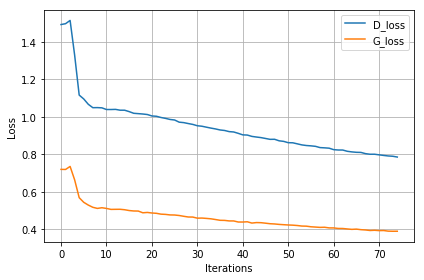

In [12]:
train_plot(hist, show= True, save=True, path='MNIST_DCGAN_results/MNIST_DCGAN_train_hist.png')

In [13]:
#Fun Stuff
images = []
images1 = []

for e in range(tr_epch):
    img_name = 'MNIST_DCGAN_results/Fixed_results/MNIST_DCGAN_' + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
    
    
imageio.mimsave('MNIST_DCGAN_results/generation_animation_fixed.gif', images, fps=5)

for e in range(tr_epch):
    img_name = 'MNIST_DCGAN_results/Random_results/MNIST_DCGAN_' + str(e + 1) + '.png'
    images1.append(imageio.imread(img_name))
    
    
imageio.mimsave('MNIST_DCGAN_results/generation_animation_random.gif', images1, fps=5)
